# Visualising the network and activity of Polymath projects: A Demo based on Polymath 1

This is a demo (and the code-cells could serve as well as a template for other PM-projects), to demonstrate the core functionalities of the comment_thread and author_activity modules for analysing and visualising the activity on Polymath.

## 1. Setting things up

We begin with setting up, and loading the urls of the different discussion-threads of the Polymath projects. We first create a dictionary with some settings that will be used by various objects and methods, and load a yaml-file that contains information that is needed to convert names and ensure that every contributor is identified by a unique name.

In [1]:
import yaml
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn-notebook')

SETTINGS = {
    'msg' : 'Polymath 1',
    'filename' : 'Polymath',
    'source' : 'pm1', # insert here the polymath in focus
    'urls' : [],
    'type' : '', # this is probably redundant,
    'parser' : 'html5lib',
    'cmap' : plt.cm.Paired, # not a string, this is an object
    'vmin' : 1,
    'vmax' : 100,
    'style': 'seaborn-notebook'
}

with open("author_convert.yaml", "r") as convert_file:
    CONVERT = yaml.safe_load(convert_file.read())

For our next step, we load a text-file that contains a fragment of html copied from the [Polymath wiki](http://michaelnielsen.org/polymath1/index.php?title=Main_Page) which lists the urls of the different threads for the Polymath-project identified by `SETTINGS['source']`. For this demo we only look at the first Polymath project. The html is parsed, and the urls and titles of the threads are stored.

A pandas DataFrame `PM_FRAME` is then created to store the results.

Because the html-structure of the discussion-threads is different for every blog (Polymath discussions take place on the blogs of Timothy Gowers, Terry Tao, and Gil Kalai as well as on the Polymath blog), information about the blog of the thread is stored in a separate column. Finally, because the activity on discussion threads and research threads is very different (we will see that many more participants are involved in the discussion threads), we put this information in a last column.

In [2]:
from bs4 import BeautifulSoup
from collections import Counter
import json
import pandas as pd
from pandas import DataFrame
from urllib.parse import urlparse


with open("DATA/" + SETTINGS['source'] + ".csv", "r") as input:
    PM_FRAME = pd.read_csv(input, index_col="Ord")

#with open("DATA/"+ SETTINGS['source'] + ".txt", "r") as input:
#    SOUP = BeautifulSoup(input.readline(), "html.parser")

#ITEMS = SOUP.find("ul").find_all("li")
#URLS = [item.find("a").get("href") for item in ITEMS]
#TITLES = [item.text for item in ITEMS]

#PM_FRAME = DataFrame({
#    'url': URLS,
#    'title' : TITLES,
#    'blog' : [urlparse(url).netloc.split('.')[0].title() for url in URLS],
#    'research' : [title.startswith(" (") for title in TITLES]},
#    columns = ['title', 'url', 'blog', 'research'])

PM_FRAME

,title,url,research
Ord,,,
0,Is massively collaborative mathematics possible?,http://gowers.wordpress.com/2009/01/27/is-mass...,False
1,A combinatorial approach to density Hales-Jewett,http://gowers.wordpress.com/2009/02/01/a-combi...,True
2,Upper and lower bounds for the density Hales-J...,http://terrytao.wordpress.com/2009/02/05/upper...,True
3,DHJ — the triangle-removal approach,http://gowers.wordpress.com/2009/02/06/dhj-the...,True
4,DHJ — quasirandomness and obstructions to unif...,http://gowers.wordpress.com/2009/02/08/dhj-qua...,True
5,DHJ — possible proof strategies,http://gowers.wordpress.com/2009/02/13/dhj-pos...,True
6,A reading seminar on density Hales-Jewett,http://terrytao.wordpress.com/2009/02/11/a-rea...,True
7,Bounds for the first few density Hales-Jewett ...,http://terrytao.wordpress.com/2009/02/13/bound...,True
8,Brief review of polymath1,http://gowers.wordpress.com/2009/02/23/brief-r...,True


Looking at this list, we can see a few things:

+ The titles of the research-threads all start with a range of numbers. These are the number of the comments; a feature that is specific for this first Polymath, where each comment was manually numbered and these numbers where then used as a reference in other comments.
+ Each research thread is in principle limited to 100 comments, and when the limit is reached a new thread (with a summary) is started.

Because this was the first Polymath project, there is a lot of meta-discussion. This is reflected in the fact that one third of the threads is a discussion thread (though this includes the discussion of the write up as well)

In [3]:
type_count = Counter(PM_FRAME['research'])
print("There are {} research threads, and {} discussion threads".format(type_count[True], type_count[False]))

There are 14 research threads, and 8 discussion threads


## 2. Parsing the source-code of the threads and creating a network
With the preliminary work done, we can start with the creation of the networks that represent each discussion-thread. For each thread a `CommentThread` is created and stored in the DataFrame. The dictionary `THREAD_TYPES` is used to select the correct sub-class of `CommentThread` to access the right parser.

`CommentThread` objects store most of the information about each comment thread in a directed graph (`networkx.DiGraph`) where single comments as nodes, and parent-child relations between comments as directed edges. Each node also stores further information about each comment as attributes. These include:

1. the author of the comment
2. a time-stamp
3. the content of each comment
4. tokenized content

in addition to more information that can be further exploited.

Finally, we add the number of comments for each thread to the DataFrame (note: this contradicts the suggested 100 comments per thread).

In [7]:
from comment_thread import *
from author_network import *

THREAD_TYPES = {"Polymath": CommentThreadPolymath,
                "Gilkalai": CommentThreadGilkalai,
                "Gowers": CommentThreadGowers,
                "Terrytao": CommentThreadTerrytao}

PM_FRAME['blog'] = PM_FRAME['url'].apply(lambda url: urlparse(url).netloc.split('.')[0].title())
PM_FRAME['thread'] = [THREAD_TYPES[blog](url) for (url, blog) in zip(PM_FRAME['url'], PM_FRAME['blog'])]
PM_FRAME['number of comments'] = PM_FRAME['thread'].apply(lambda x: len(x.node_name.keys()))

PM_FRAME.head()

,title,url,research,blog,thread,number of comments
Ord,,,,,,
0,Is massively collaborative mathematics possible?,http://gowers.wordpress.com/2009/01/27/is-mass...,False,Gowers,<comment_thread.CommentThreadGowers object at ...,76
1,A combinatorial approach to density Hales-Jewett,http://gowers.wordpress.com/2009/02/01/a-combi...,True,Gowers,<comment_thread.CommentThreadGowers object at ...,181
2,Upper and lower bounds for the density Hales-J...,http://terrytao.wordpress.com/2009/02/05/upper...,True,Terrytao,<comment_thread.CommentThreadTerrytao object a...,91
3,DHJ — the triangle-removal approach,http://gowers.wordpress.com/2009/02/06/dhj-the...,True,Gowers,<comment_thread.CommentThreadGowers object at ...,70
4,DHJ — quasirandomness and obstructions to unif...,http://gowers.wordpress.com/2009/02/08/dhj-qua...,True,Gowers,<comment_thread.CommentThreadGowers object at ...,114


Single comments threads are not our primary object of study. We are primarily interested in total Polymath projects, as well as in specific fragments of these projects. To study the growth of the project, we cummulatively merge the different `CommentThread` objects in `MultiCommentThread` objects in the following seven ways:

1. Only research threads
2. Only discussion threads
3. Only threads on Gowers' blog.
4. Only research threads on Gowers' blog.
5. Only threads on Tao's blog.
6. Only research threads on Tao's blog.
7. All threads

Of these, 1, 2 and 7 are the primary focus. The separation of Gowers and Tao are only considered in Section 6.

Because plotting methods are part of `MultiCommentThread` each thread is also stored as such an object as well.

In [8]:
from pandas import Series

is_gowers = PM_FRAME['blog']=='Gowers'
is_tao = PM_FRAME['blog']=='Terrytao'

indices = PM_FRAME.index
r_indices = PM_FRAME[PM_FRAME['research']].index
d_indices = PM_FRAME[~PM_FRAME['research']].index
gow_indices = PM_FRAME[is_gowers].index
tao_indices = PM_FRAME[is_tao].index
gow_rindices = PM_FRAME[is_gowers & PM_FRAME['research']].index
tao_rindices = PM_FRAME[is_tao & PM_FRAME['research']].index



threads = PM_FRAME.thread
r_threads = PM_FRAME[PM_FRAME['research']].thread
d_threads = PM_FRAME[~PM_FRAME['research']].thread
gow_threads = PM_FRAME[is_gowers].thread
tao_threads = PM_FRAME[is_tao].thread
gow_rthreads = PM_FRAME[is_gowers & PM_FRAME['research']].thread
tao_rthreads = PM_FRAME[is_tao & PM_FRAME['research']].thread



# all threads
PM_FRAME['mthread (single)'] = PM_FRAME['thread'].apply(MultiCommentThread)
PM_FRAME['mthread (accumulated)'] = Series([MultiCommentThread(*threads[0:i+1]) for i in indices],
                                            index=indices)

# only research
PM_FRAME['r_mthread (accumulated)'] = Series([MultiCommentThread(*r_threads[0:i+1]) for i in r_indices],
                                               index=r_indices)


# only discussion
PM_FRAME['d_mthread (accumulated)'] = Series([MultiCommentThread(*d_threads[0:i+1]) for i in d_indices],
                    index=d_indices)

# only gowers
PM_FRAME['gow_mthread (accumulated)'] = Series([MultiCommentThread(*gow_threads[0:i+1]) for i in gow_indices],
                    index=gow_indices)
PM_FRAME['gow_r_mthread (accumulated)'] = Series([MultiCommentThread(*gow_rthreads[0:i+1]) for i in gow_rindices],
                    index=gow_rindices)

# only tao
PM_FRAME['tao_mthread (accumulated)'] = Series([MultiCommentThread(*tao_threads[0:i+1]) for i in tao_indices],
                    index=tao_indices)
PM_FRAME['tao_r_mthread (accumulated)'] = Series([MultiCommentThread(*tao_rthreads[0:i+1]) for i in tao_rindices],
                    index=tao_rindices)

## 3. Getting at the social structure: interaction networks

To understand the collaborative dynamics and organisation behind Polymath projects we do not only need to look at the structure of discussions. *Side remark:* As it stands, the structure of the discussion is only partially revealed, since only formal parent-child links are recorded, but not every reference to other comments that is made. This is particularly true for Polymath 1, where the manual numbering is extensively used.

A better insight in the collaborative structure is captured by interaction-networks between the different participants. These networks are stored as weighted directerd graphs in `AuthorNetwork` objects. Here, participants are nodes and interactions are directed edges. The weight of each edge depends on the number of times a participant commented on a comment of another participant.

We create an `AuthorNetwork` for each accumulated `MultiCommentThread` in our table, and finish by reorganising and cleaning up the table.

In [9]:
PM_FRAME['network'] = PM_FRAME['mthread (accumulated)'].apply(AuthorNetwork)
PM_FRAME['r_network'] = PM_FRAME[PM_FRAME['research']]['r_mthread (accumulated)'].apply(AuthorNetwork)
PM_FRAME['d_network'] = PM_FRAME[~PM_FRAME['research']]['d_mthread (accumulated)'].apply(AuthorNetwork)
PM_FRAME['gow_network'] = PM_FRAME[is_gowers]['gow_mthread (accumulated)'].apply(AuthorNetwork)
PM_FRAME['tao_network'] = PM_FRAME[is_tao]['tao_mthread (accumulated)'].apply(AuthorNetwork)
PM_FRAME['gow_r_network'] = PM_FRAME[is_gowers & PM_FRAME['research']]['gow_r_mthread (accumulated)'].apply(AuthorNetwork)
PM_FRAME['tao_r_network'] = PM_FRAME[is_tao & PM_FRAME['research']]['tao_r_mthread (accumulated)'].apply(AuthorNetwork)

PM_FRAME = PM_FRAME.reindex_axis(['title', 'url', 'blog', 'research', 'number of comments',
                        'thread', 'mthread (single)',
                        'mthread (accumulated)', 'network',
                        'r_mthread (accumulated)', 'r_network',
                        'd_mthread (accumulated)', 'd_network',
                        'gow_mthread (accumulated)', 'gow_network',
                        'gow_r_mthread (accumulated)', 'gow_r_network',
                        'tao_mthread (accumulated)', 'tao_network',
                        'tao_r_mthread (accumulated)', 'tao_r_network'],
                        axis=1)


PM_FRAME.index = pd.MultiIndex.from_tuples([(SETTINGS['msg'], i) for i in indices],
                                      names=['Project', 'Ord'])

PM_FRAME.head()

title  \
Project    Ord                                                      
Polymath 1 0     Is massively collaborative mathematics possible?   
           1     A combinatorial approach to density Hales-Jewett   
           2    Upper and lower bounds for the density Hales-J...   
           3                  DHJ — the triangle-removal approach   
           4    DHJ — quasirandomness and obstructions to unif...   

                                                              url      blog  \
Project    Ord                                                                
Polymath 1 0    http://gowers.wordpress.com/2009/01/27/is-mass...    Gowers   
           1    http://gowers.wordpress.com/2009/02/01/a-combi...    Gowers   
           2    http://terrytao.wordpress.com/2009/02/05/upper...  Terrytao   
           3    http://gowers.wordpress.com/2009/02/06/dhj-the...    Gowers   
           4    http://gowers.wordpress.com/2009/02/08/dhj-qua...    Gowers   

               research  number of comments  \
Project    Ord                                
Polymath 1 0      False                  76   
           1       True                 181   
           2       True                  91   
           3       True                  70   
           4       True                 114   

                                                           thread  \
Project    Ord                                                      
Polymath 1 0    <comment_thread.CommentThreadGowers object at ...   
           1    <comment_thread.CommentThreadGowers object at ...   
           2    <comment_thread.CommentThreadTerrytao object a...   
           3    <comment_thread.CommentThreadGowers object at ...   
           4    <comment_thread.CommentThreadGowers object at ...   

                                                 mthread (single)  \
Project    Ord                                                      
Polymath 1 0    <comment_thread.MultiCommentThread object at 0...   
           1    <comment_thread.MultiCommentThread object at 0...   
           2    <comment_thread.MultiCommentThread object at 0...   
           3    <comment_thread.MultiCommentThread object at 0...   
           4    <comment_thread.MultiCommentThread object at 0...   

                                            mthread (accumulated)  \
Project    Ord                                                      
Polymath 1 0    <comment_thread.MultiCommentThread object at 0...   
           1    <comment_thread.MultiCommentThread object at 0...   
           2    <comment_thread.MultiCommentThread object at 0...   
           3    <comment_thread.MultiCommentThread object at 0...   
           4    <comment_thread.MultiCommentThread object at 0...   

                                                          network  \
Project    Ord                                                      
Polymath 1 0    <author_network.AuthorNetwork object at 0x115c...   
           1    <author_network.AuthorNetwork object at 0x115c...   
           2    <author_network.AuthorNetwork object at 0x115c...   
           3    <author_network.AuthorNetwork object at 0x115c...   
           4    <author_network.AuthorNetwork object at 0x115c...   

                                          r_mthread (accumulated)  \
Project    Ord                                                      
Polymath 1 0                                                  NaN   
           1    <comment_thread.MultiCommentThread object at 0...   
           2    <comment_thread.MultiCommentThread object at 0...   
           3    <comment_thread.MultiCommentThread object at 0...   
           4    <comment_thread.MultiCommentThread object at 0...   

                                      ...                          \
Project    Ord                        ...                           
Polymath 1 0                          ...                           
           1                          ...                        

## 4. Visualising the development of the discussion threads

We are now ready to visualise the information we stored in various networks. We start by representing the complete comment structure of Polymath 1.

In this figure the form of the nodes signals the blog where the comment was made, and the colour uniquely identifies each author in the figure and across all the subsequent figures. Here, we do not look separately at research and discussion threads.

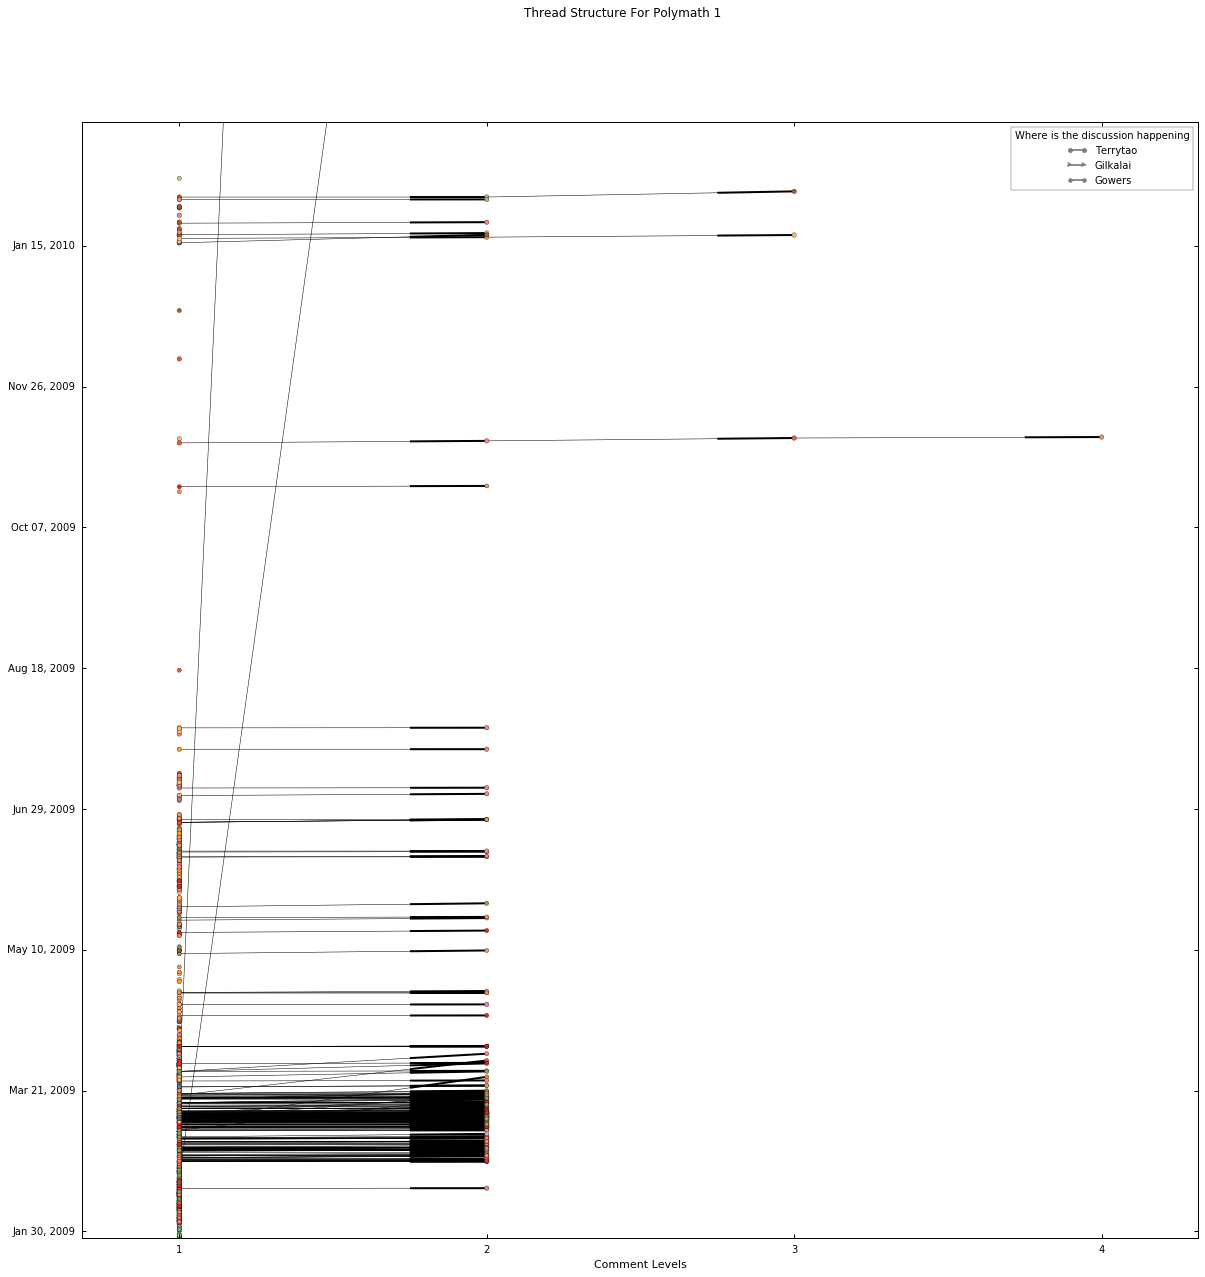

In [10]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 20)

PM_FRAME['mthread (accumulated)'].iloc[-1].draw_graph(project="Polymath 1", intervals=50, last="2010-02-28")
# PM_FRAME['r_mthread (accumulated)'].dropna().iloc[-1].draw_graph(time_intervals=50)
# PM_FRAME['d_mthread (accumulated)'].dropna().iloc[-1].draw_graph(time_intervals=50)

Another interesting feature to look at it how the activity evolves in the subsequent threads. We first look at all the threads of Polymath 1 (while cutting off some late comments in the earlier threads).

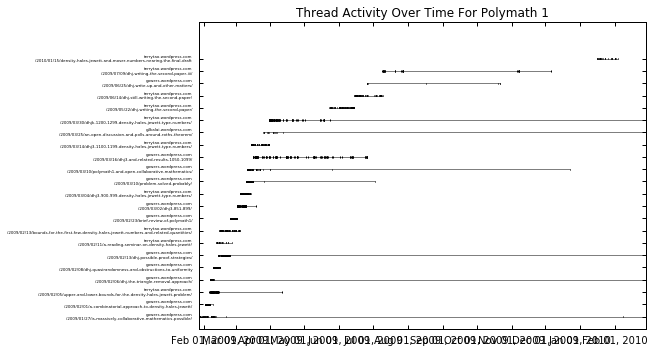

In [11]:
PM_FRAME['mthread (accumulated)'].iloc[-1].plot_activity('thread', project="Polymath 1", intervals=1, last="2010-02-28")

And then look at research and discussion threads separately, while cutting of even more late comments in the earlier threads.

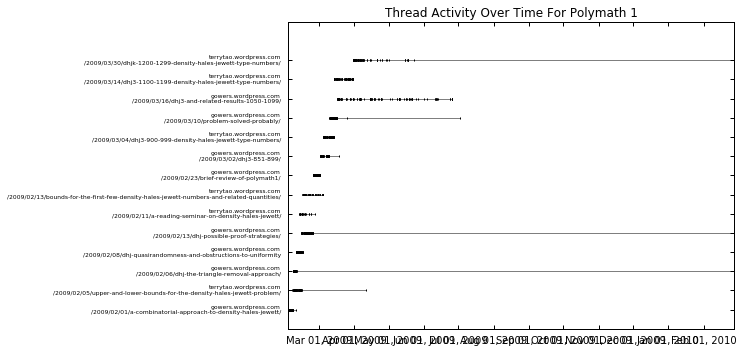

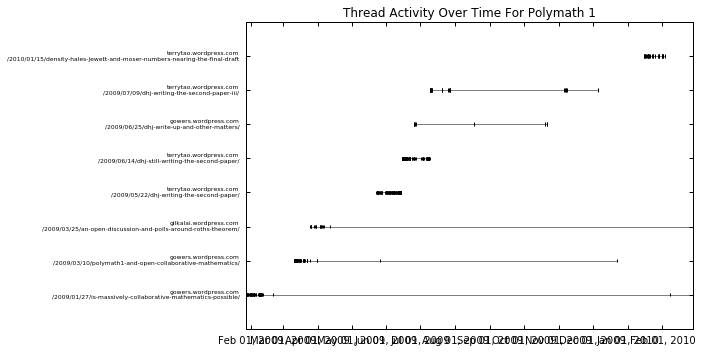

In [12]:
PM_FRAME['r_mthread (accumulated)'].dropna().iloc[-1].plot_activity('thread', intervals=1, last="2010-02-28")
PM_FRAME['d_mthread (accumulated)'].dropna().iloc[-1].plot_activity('thread', intervals=1, last="2010-02-28")

And the overall growth of the discussion (cutting of after July 2009 when the growth slows down)

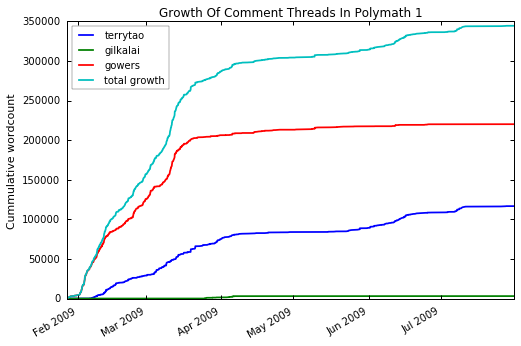

In [13]:
PM_FRAME['mthread (accumulated)'].iloc[-1].plot_growth(project="Polymath 1", last="2009-07-31")

Looking at research and discussion separately reveals two entirely different dynamics: a steady, but continuous growth during 5 months in the research threads and short bursts of intense discussion threads with little activity in between. (but note the difference in scale: research reaches more than 250,000 words, but discussion accounts for over 70,000 words)

It's interesting to match the slow-down in research-contributions (at least in number of word counts) to the development of the individual threads pictured earlier. This allow us to situate the slowdown at the end of the (1100-1199) thread on Tao's blog. After this point, a slow discussion goes on in parrallel between the preceding thread on Gowers' blog and the subsequent thread at Tao's blog. **(should we look at the content to see if this is a period where all are convinced that the result is mostly complete. The "probabaly solved" announcement is even earlier in March)**

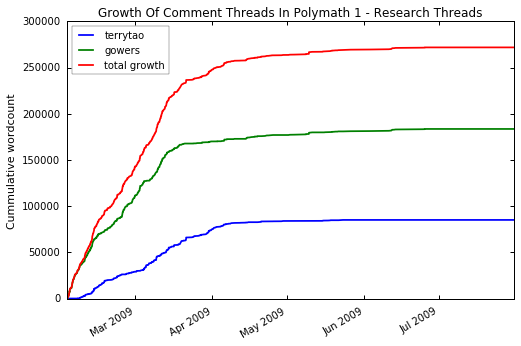

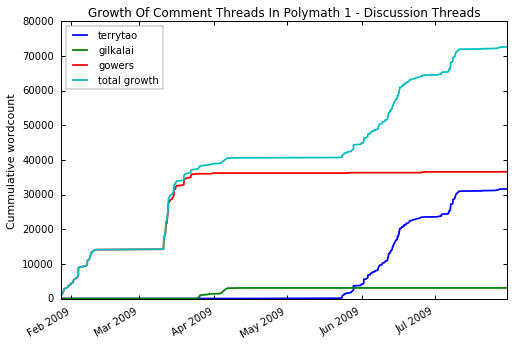

In [14]:
PM_FRAME['r_mthread (accumulated)'].dropna().iloc[-1].plot_growth(project="Polymath 1 - research threads", last="2009-07-31")
PM_FRAME['d_mthread (accumulated)'].dropna().iloc[-1].plot_growth(project="Polymath 1 - discussion threads", last="2009-07-31")

## 5. Visualising Author Activity and Interaction

We begin by just looking at the number of participants in the research and discussion threads, as well as the number of their comments. Here, we immediatel notice that a small number of participants is responsible for the vast majority of the contributions. The research threads are the most extreme example, with more than half of the comments due to only 3 contributors. In the discussion threads it is still true that only 5 participants account for half of the comments, but we also see a sizable ammount of occasional engagement: 25% of the participants contributed less than 5 comments each. This could be accounted for by an initial wide enhousiasm for Polymath as an online collaborative entrprise. It wouldn't be surprising if this trend would be specific for Polymath 1 (though the more accessible Mini-Polymaths look very different as well).

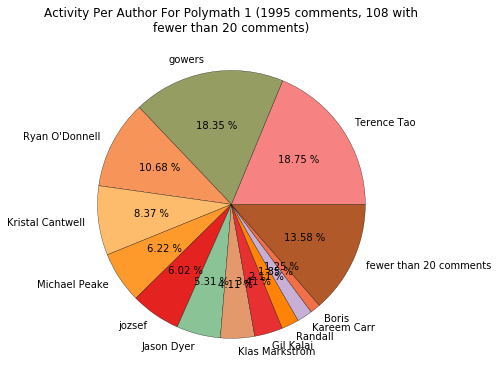

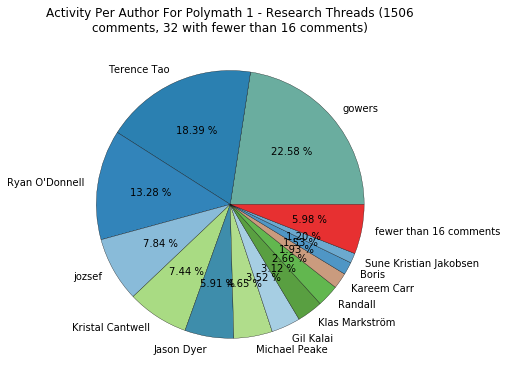

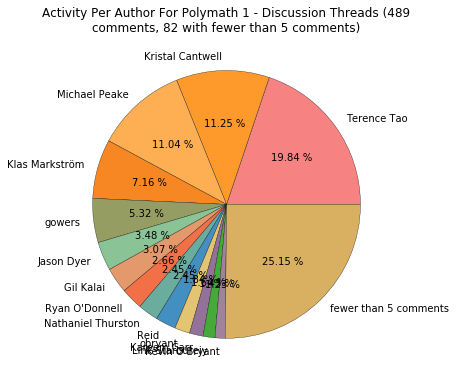

In [15]:
PM_FRAME['network'].iloc[-1].plot_author_activity_pie(project="Polymath 1")
PM_FRAME['r_network'].dropna().iloc[-1].plot_author_activity_pie(project="Polymath 1 - research threads")
PM_FRAME['d_network'].dropna().iloc[-1].plot_author_activity_pie(project="Polymath 1 - discussion threads")

If we look at the total length of the comments instead of the number of comments, the role of the *big contributors* is even more marked. (Here, we only look at the totality, and at the research threads). It is now very clear that Tao and Gowers are responsible for half of the comments (i.e. the content of the blog-posts themselves, which are meant as summaries of the previous threads and a plan for how to proceed further, isn't even taken into account here).

**Remark:** The word-count figures are approximate at best. Since LaTeX is rendered as images, it doesn't show up as text in the html and can therefore not be counted.

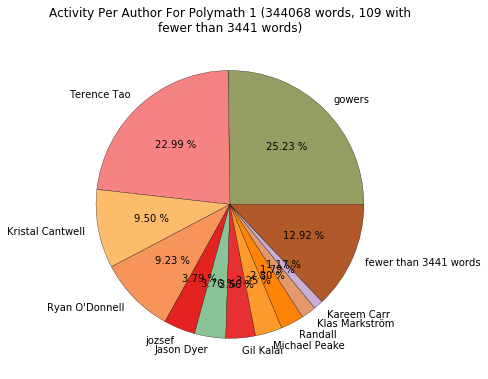

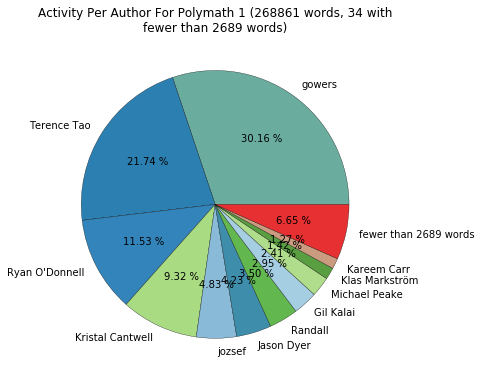

In [16]:
PM_FRAME['network'].iloc[-1].plot_author_activity_pie(project="Polymath 1", what="word counts")
PM_FRAME['r_network'].dropna().iloc[-1].plot_author_activity_pie(project="Polymath 1", what="word counts")

Looking at author-engagement over time doesn't add much to this picture: highly active participants are also active over a long period, but at least some occasional contributors have contribitions that are not concentrated in time.

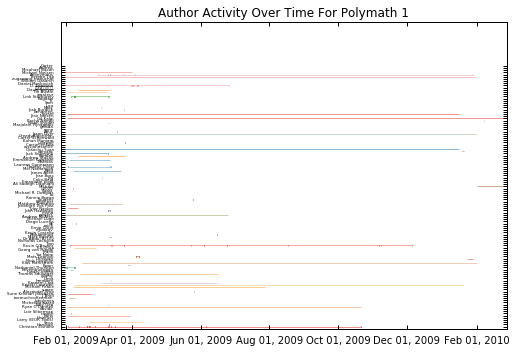

In [17]:
PM_FRAME['mthread (accumulated)'].iloc[-1].plot_activity('author', intervals=2, project="Polymath 1", last="2010-02-28")

We can also look at author-engagement by considering comments and replies separately, and by looking at the histogram. This only further underscores what we already noticed. (though the comparison by levels may be more revealing in the later projects, since "threading" was only enabled in the "Brief review of polymath1" thread which is after the completion of the 7th research thread.) 

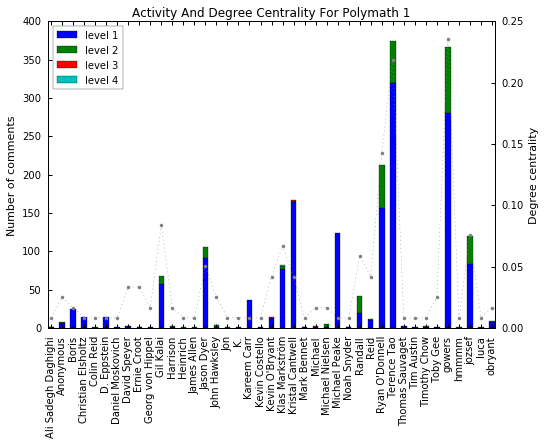

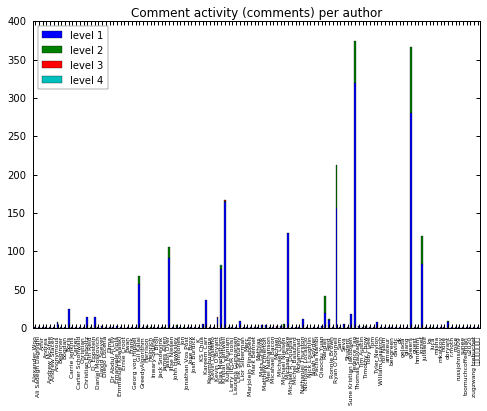

In [18]:
PM_FRAME['network'].iloc[-1].plot_activity_degree(project="Polymath 1")
PM_FRAME['network'].iloc[-1].plot_author_activity_bar(project="Polymath 1")
#PM_FRAME['network'].iloc[-1].plot_author_activity_bar(what="word counts")

The interaction-network gives us no doubt more insight. Again, we look separately at the totality and at the disjoint research and discussion threads.

In these graphs, the size of the nodes is proportional to the number of comments (log scale). The edges signal, as indicated before, the intensity and direction of the interaction between participants.

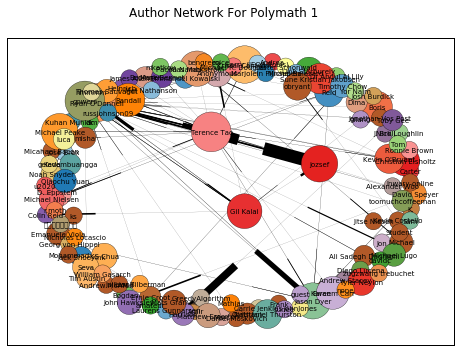

In [19]:
PM_FRAME['network'].iloc[-1].draw_graph(project="Polymath 1")

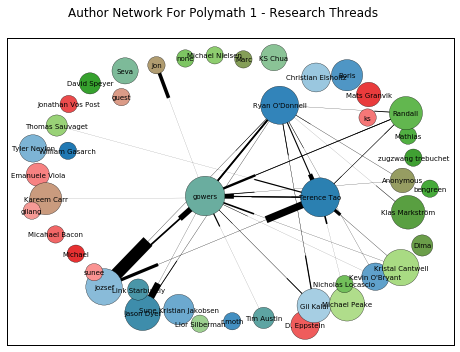

In [20]:
PM_FRAME['r_network'].dropna().iloc[-1].draw_graph(project="Polymath 1 - Research threads")

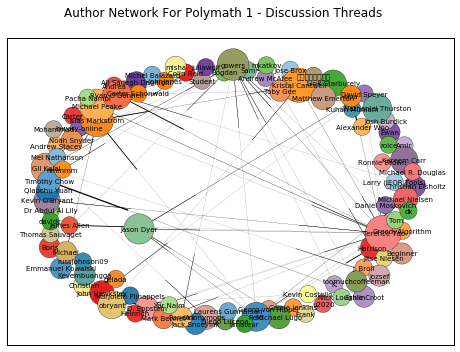

In [21]:
PM_FRAME['d_network'].dropna().iloc[-1].draw_graph(project="Polymath 1 - Discussion threads")

In addition to the previously uncovered patterns, we now also notice that:

1. Highly active contributors in the research threads come in at least two kinds: highly interactive, like Tao and Gowers, and less interactive, like Kristal Cantwell. (this may be an artefact due to the inexistend interactivity in the earlier threads)
2. Research threads do not only contain fewer participants, but also more actively participants (and perhaps more intricate dicussions). Discussion threads are, at first sight, much less connected.

This last feature is supported by a comparison of the weakly connected components of both interaction networks.

In [22]:
RESEARCH_COMPONENTS = list(PM_FRAME['r_network'].dropna().iloc[-1].w_connected_components())
DISCUSSION_COMPONENTS = list(PM_FRAME['d_network'].dropna().iloc[-1].w_connected_components())

RESEARCH_COMPONENTS
DISCUSSION_COMPONENTS

[{'Ali Sadegh Daghighi',
  'Anonymous',
  'Boris',
  'Christian Elsholtz',
  'Colin Reid',
  'D. Eppstein',
  'Daniel Moskovich',
  'David Speyer',
  'Ernie Croot',
  'Georg von Hippel',
  'Gil Kalai',
  'Harrison',
  'Heinrich',
  'James Allen',
  'Jason Dyer',
  'John Hawksley',
  'K.',
  'Kevin Costello',
  "Kevin O'Bryant",
  'Klas Markström',
  'Kristal Cantwell',
  'Mark Bennet',
  'Michael',
  'Michael Nielsen',
  'Michael Peake',
  'Noah Snyder',
  'Randall',
  'Reid',
  "Ryan O'Donnell",
  'Terence Tao',
  'Timothy Chow',
  'Toby Gee',
  'gowers',
  'hmmmm',
  'jozsef',
  'luca',
  'obryant'},
 {'Larry (IEOR Tools)'},
 {'Inwary-online'},
 {'Michel Balazard'},
 {'Kevembuangga'},
 {'toomuchcoffeeman'},
 {'J. Broll'},
 {'Alexander Woo'},
 {'Kareem Carr'},
 {'Thomas Sauvaget'},
 {'JohnJones'},
 {'Nathaniel Thurston'},
 {'Ewan'},
 {'Sam'},
 {'Nick Loughlin'},
 {'Christian'},
 {'Yor Naim'},
 {'Frank'},
 {'Tom'},
 {'Dr Abdul Al Lily'},
 {'Amir'},
 {'mkatkov'},
 {'roice'},
 {'dk'},
 {

## 6. A Closer Look at the Parallel Development in PM1

The parallel development of Polymath that occured with the start of parallel research threads on Tao's blog has already been noted in the literature **reference needed**. Let us see if we can differentiate them by only looking at structural features of the comment threads and interaction networks.

A first obvious question is whether Tao and Gowers really surface as the leaders on their own blogs, and are less visible on each other's blogs, or if they really ensure the communication between the blogs.

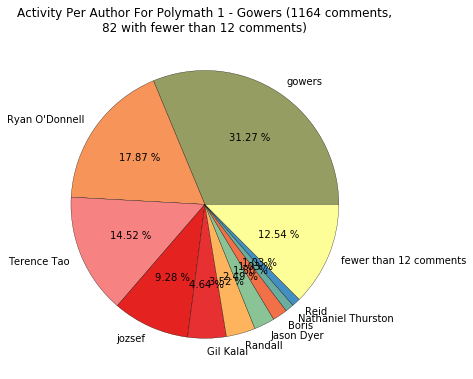

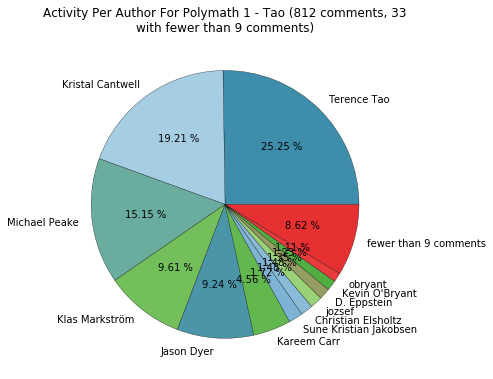

In [23]:
PM_FRAME['gow_network'].dropna().iloc[-1].plot_author_activity_pie(project="Polymath 1 - Gowers")
PM_FRAME['tao_network'].dropna().iloc[-1].plot_author_activity_pie(project="Polymath 1 - Tao")

The pie-charts below reveal that Terry Tao is prominently present on Gowers' blog, but that Gowers is less present on Tao's blog. This is not the only notable feature: there is indeed very little overlap in participant overall. As such, these facts support the idea of a parallel development: there is very little overlap in both enquiries (**insight from the actual content may help here**). Purely from the standpoint of the underlying social network, this reveals some interesting features; in particular the suggestion that Terry Tao and jozsef are among the very few links between two sub-communities. (keep in mind that we have no idea on passive participation: only comments leave a trace)

The diagrams and table below make these claims more precise. There are 20 participants that bridge Gowers with Tao, but only few of them are prominently active on both sides. This feature is particularly noteworthy since some of the most active contributors are only visible on one side.

Common commenters: 
Christian Elsholtz      commented 2     times on Gowers' blog and 12    times on Tao's blog
Kristal Cantwell        commented 11    times on Gowers' blog and 156   times on Tao's blog
Gil Kalai               commented 54    times on Gowers' blog and 6     times on Tao's blog
Sune Kristian Jakobsen  commented 4     times on Gowers' blog and 14    times on Tao's blog
Anonymous               commented 5     times on Gowers' blog and 2     times on Tao's blog
Kevin O'Bryant          commented 4     times on Gowers' blog and 10    times on Tao's blog
Boris                   commented 21    times on Gowers' blog and 3     times on Tao's blog
jozsef                  commented 108   times on Gowers' blog and 12    times on Tao's blog
David Speyer            commented 1     times on Gowers' blog and 2     times on Tao's blog
Tyler Neylon            commented 3     times on Gowers' blog and 5     times on Tao's blog
D. Eppstein             commented 3     times on Gowers' blo

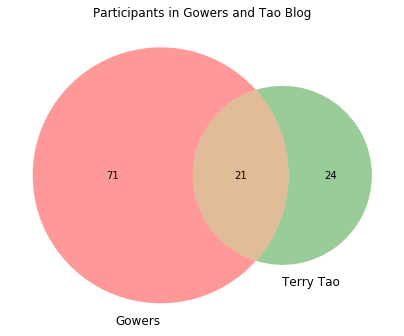

In [24]:
from matplotlib_venn import venn2, venn3

GOWERS = PM_FRAME['gow_network'].dropna().iloc[-1].author_frame
TAO = PM_FRAME['tao_network'].dropna().iloc[-1].author_frame

print("Common commenters: ")
for common in set(GOWERS.index).intersection(set(TAO.index)):
    print("{:<23} commented {:<5g} times on Gowers' blog and {:<5g} times on Tao's blog".format(
            common,
            GOWERS['total comments'][common],
            TAO['total comments'][common]))

plt.figure()
venn2([set(GOWERS.index), set(TAO.index)], set_labels = ['Gowers', 'Terry Tao'])
plt.title('Participants in Gowers and Tao Blog')
plt.show()

If we narrow down our attention to research threads only, the patter remains similar:

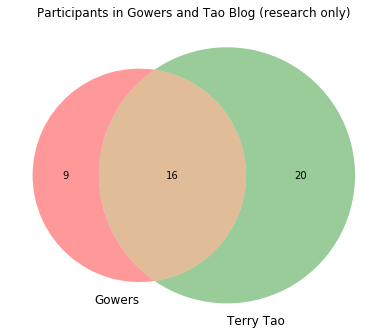

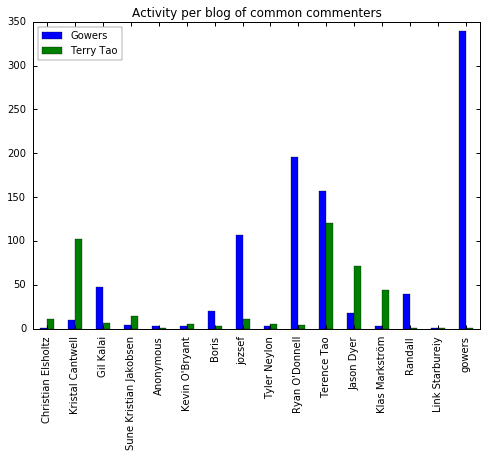

In [35]:
R_GOWERS = PM_FRAME['gow_r_network'].dropna().iloc[-1].author_frame
R_TAO = PM_FRAME['tao_r_network'].dropna().iloc[-1].author_frame

common = list(set(R_GOWERS.index).intersection(set(R_TAO.index)))
common_frame = DataFrame({'Gowers': R_GOWERS['total comments'][common],
                          'Terry Tao' : R_TAO['total comments'][common]})


plt.figure()
venn2([set(R_GOWERS.index), set(R_TAO.index)], set_labels = ['Gowers', 'Terry Tao'])
plt.title('Participants in Gowers and Tao Blog (research only)')
plt.show()

common_frame.plot(kind="bar", title="Activity per blog of common commenters")

By way of comparison, we look at the overlap between research and discussion threads. The difference in size was already noted, but it is also surprising that more than half of the contributors to the research threads did not contribute to discussion threads. This may be explained by the fact that almost all "research only" commenters are occasional commenters.

Research-only commenters:
Seva                    commented 6   times
Sune Kristian Jakobsen  commented 18  times
Jon                     commented 1   times
r.moth                  commented 1   times
Lior Silberman          commented 1   times
Mathias                 commented 1   times
Jonathan Vos Post       commented 1   times
sunee                   commented 1   times
Emanuele Viola          commented 3   times
Dima                    commented 2   times
gilang                  commented 1   times
none                    commented 1   times
Mats Granvik            commented 4   times
KS Chua                 commented 6   times
bengreen                commented 1   times
Marc                    commented 1   times
Nicholas Locascio       commented 1   times
zugzwang trebuchet      commented 1   times
Tim Austin              commented 2   times
Tyler Neylon            commented 8   times
guest                   commented 1   times
William Gasarch         commented 1   times
ks    

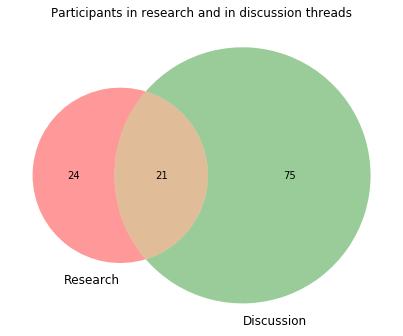

In [26]:
RES = PM_FRAME['r_network'].dropna().iloc[-1].author_frame
DISC = PM_FRAME['d_network'].dropna().iloc[-1].author_frame

RES_ONLY = set(RES.index).difference(set(DISC.index))

print("Research-only commenters:")
for commenter in RES_ONLY:
    print("{:<23} commented {:<3g} times".format(commenter, RES['total comments'][commenter]))


plt.figure()
venn2([set(RES.index), set(DISC.index)], set_labels = ['Research', 'Discussion'])
plt.title('Participants in research and in discussion threads')
plt.show()

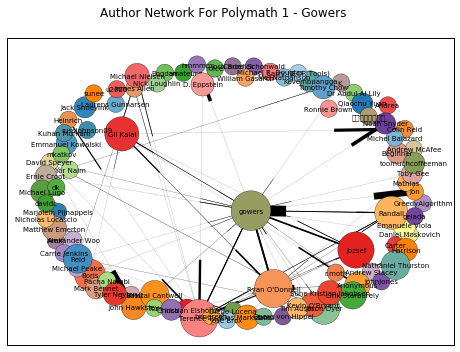

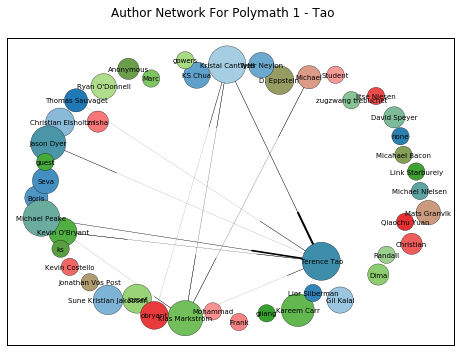

In [27]:
PM_FRAME['gow_network'].dropna().iloc[-1].draw_graph(project="Polymath 1 - Gowers")
PM_FRAME['tao_network'].dropna().iloc[-1].draw_graph(project="Polymath 1 - Tao")

## 7. Understanding Roles in te Collaboration

The overwhelming presence of Gowers/Tao does not necessarily mean that they really did the most work, or give the most valuable input. How could we understand their place in the discussion?

A partial answer is already implicit in the discussion in the previous section: both Gowers and Tao not only contribute most, but also interact most. Looking at their respective blogs separately revealed morover that Tao was highly interactive on both blogs, whereas Gowers was only very active on his own blog.

This impression can be more precise by looking at centrality-metrics for the relevant interaction-graphs. We consider specifically the degree-centrality, as this is a normalised measure and allows us to compare the Gowers and Tao blogs despite their difference in size **(@JP: Heb ik dit correct begrepen?)**

And indeed (the graph omits the non-connected contributors to improve legibility), this confirms the visual impression we got from the networks: Gowers is the most connected contributor on his own blog, with Tao as second most connected, whereas Tao is the most connected contributor on hiw own blog, and Gowers absent.

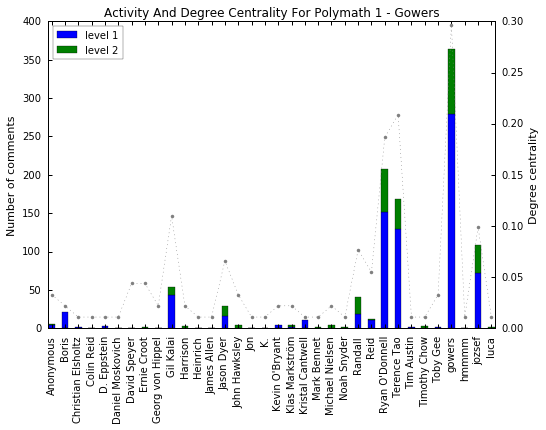

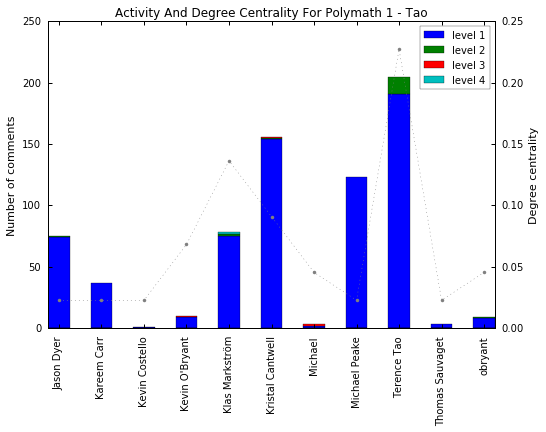

In [28]:
PM_FRAME['gow_network'].dropna().iloc[-1].plot_activity_degree(project="Polymath 1 - Gowers")
PM_FRAME['tao_network'].dropna().iloc[-1].plot_activity_degree(project="Polymath 1 - Tao")

To confirm that these insights are not caused by the fact that several threads on Gowers' blog did not run in parallel with a thread on Tao's blog (i.e. points at which the discussion was centralised), we take a look at the interaction network of a single Gowers thread that ran in parallel with a succession of threads on Tao's blog. Here too, we see that Tao is clearly present. **What this exactly means for our understanding of the different roles assumed by Gowers and Tao is not easily determined without looking at the actual content. **

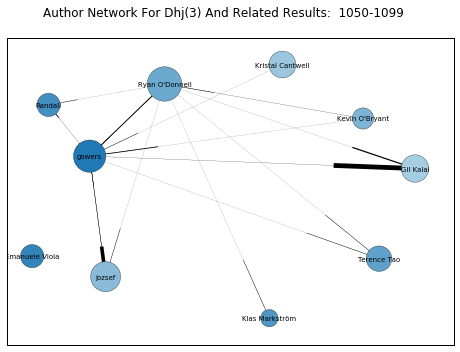

In [29]:
A_GOWERS_NETWORK = AuthorNetwork(PM_FRAME['mthread (single)'].iloc[13])
A_GOWERS_NETWORK.draw_graph(project=list(PM_FRAME['title'])[13].strip())
